# Atlas of Mexican Cities

This notebook presents the analyses and results of the "Atlas of Mexican Cities" project. The goal of this project is to develop an exploratory geojson that characterizes and compares the most important cities in Mexico through a methodology based on open data. We will explore various urban dimensions, such as demographics, urban development, and segregation, using different data sources.

The notebook is organized into the following sections:

### Censuses
In this section (see [Population Censuses](#Population-censuses)), we will explore the population censuses of Mexico from 1990, 2000, 2010, and 2020. We will examine trends in population growth and demographic changes across the country.

### SUN
In this section (see [National Urban System (SUN)](#national-urban-system-\(sun\))), we will use the National Urban System (SUN) to examine the distribution of population, economic activity, and urban influence across the cities of Mexico.

### Geospatial Exploration
In this section (see [Geospatial Exploration](#geospatial-exploration_)), we will explore the geostatistical framework and raster maps of built-up areas to examine patterns of urban growth and land use change over time.

### Merging
In this section (see [Merging](#merging_)), we will merge and integrate the different datasets to provide a comprehensive view of the urban landscape in Mexico.

### Optimized Pipeline System
In this section (see [Optimized Pipeline System](#optimized-pipeline-system_)), we will implement all of the analyses as an optimized pipeline system. Each analysis will be configured as an independent analysis, and the results will be merged at the end to produce the final exploratory geojson.

We hope that this exploratory geojson will be a useful tool for better understanding urban growth in Mexico and for making informed decisions in urban and territorial planning in the country.


In [1]:
# libs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import re
import rasterio as rio
from rasterio import mask
from rasterstats import zonal_stats
from pathlib import Path
from shapely.geometry import Polygon
import sys

pd.options.display.float_format = '{:,.2f}'.format


# Population Censuses

In this section, we will prepare the population census data from 1990, 2000, 2010, and 2020 for merging with other datasets. We will explore trends in population growth and demographic changes across the country, and clean and reformat the data as necessary.

The data for each census is available for download from the INEGI website. Here are the direct download links for each dataset:

- [1990 Population Census Data](https://www.inegi.org.mx/contenidos/programas/ccpv/1990/microdatos/iter/00_nacional_1990_iter_txt.zip)
- [2000 Population Census Data](https://www.inegi.org.mx/contenidos/programas/ccpv/2000/datosabiertos/cgpv2000_iter_00_csv.zip)
- [2010 Population Census Data](https://www.inegi.org.mx/contenidos/programas/ccpv/2010/datosabiertos/iter_nal_2010_csv.zip)
- [2020 Population Census Data](https://www.inegi.org.mx/contenidos/programas/ccpv/2020/microdatos/iter/ITER_NAL_2020_csv.zip)

### 1990 Census

In [2]:
# Load 1990 Population Census Data
df_1990 = pd.read_csv('../data/ITER_NALTXT90.csv', sep="\t" , encoding='latin-1')
df_1990

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/283265698.py:2: DtypeWarning: Columns (6,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1990 = pd.read_csv('../data/ITER_NALTXT90.csv', sep="\t" , encoding='latin-1')


,entidad,nom_ent,mun,nom_mun,loc,nom_loc,longitud,latitud,altitud,p_total,...,prom_cua,pared_la,techo_la,piso_tie,viv_1_c,viv_2_c,c_agua_ent,c_drenaje,c_e_elect,viv_pprop
0,0,Total nacional,0,Total nacional,0,TOTAL NACIONAL,NaN,NaN,NaN,"81,249,645.00",...,1.46,339382,1926309,12824676,1682020,2640608,12258825,10202934,14033451,12486898
1,0,Total nacional,0,Total nacional,9998,LOCALIDADES DE UNA VIVIENDA,NaN,NaN,NaN,"235,955.00",...,1.72,1290,6665,27004,5420,10393,12726,8019,13095,23461
2,0,Total nacional,0,Total nacional,9999,LOCALIDADES DE DOS VIVIENDAS,NaN,NaN,NaN,"181,717.00",...,1.86,1208,6071,18235,5004,8958,9588,5413,10130,21401
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,TOTAL DE LA ENTIDAD,NaN,NaN,NaN,"719,659.00",...,1.37,932,6598,120885,6237,12091,123093,111787,123426,95503
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,LOCALIDADES DE UNA VIVIENDA,NaN,NaN,NaN,"2,857.00",...,1.81,6,47,386,16,67,225,130,265,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162191,32,Zacatecas,56,Zacatecas,111,"LADRILLERAS, LAS",NaN,NaN,NaN,21.00,...,4.20,0,0,2,2,0,0,0,0,2
162192,32,Zacatecas,56,Zacatecas,112,"VARELA, LOS",NaN,NaN,NaN,12.00,...,1.71,0,0,3,0,2,0,0,0,3
162193,32,Zacatecas,56,Zacatecas,113,"CENTENARIO, EL",NaN,NaN,NaN,12.00,...,1.71,0,0,3,0,2,0,0,3,3
162194,32,Zacatecas,56,Zacatecas,9998,LOCALIDADES DE UNA VIVIENDA,NaN,NaN,NaN,53.00,...,1.77,0,3,11,2,3,2,0,4,5


In [3]:
# Select only the necessary columns
df_1990 = df_1990[['entidad', 'nom_ent', 'mun', 'nom_mun', 'loc', 'nom_loc', 'p_total']]
df_1990

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total
0,0,Total nacional,0,Total nacional,0,TOTAL NACIONAL,"81,249,645.00"
1,0,Total nacional,0,Total nacional,9998,LOCALIDADES DE UNA VIVIENDA,"235,955.00"
2,0,Total nacional,0,Total nacional,9999,LOCALIDADES DE DOS VIVIENDAS,"181,717.00"
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,TOTAL DE LA ENTIDAD,"719,659.00"
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,LOCALIDADES DE UNA VIVIENDA,"2,857.00"
...,...,...,...,...,...,...,...
162191,32,Zacatecas,56,Zacatecas,111,"LADRILLERAS, LAS",21.00
162192,32,Zacatecas,56,Zacatecas,112,"VARELA, LOS",12.00
162193,32,Zacatecas,56,Zacatecas,113,"CENTENARIO, EL",12.00
162194,32,Zacatecas,56,Zacatecas,9998,LOCALIDADES DE UNA VIVIENDA,53.00


In the dataset there are general information of the locations, municipalities and the country that is indexed in the dataset, these information is not neccesary for this analysis, the target information is differentiated by the column nom_loc which contains the string "TOTAL MUNICIPAL", it can be used to choose those rows that are relevant.

In [4]:
# 1990 total pob
df_1990_simplied = df_1990.query('nom_loc.str.contains("TOTAL MUNICIPAL")')
df_1990_simplied

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total
6,1,Aguascalientes,1,Aguascalientes,0,TOTAL MUNICIPAL,"506,274.00"
581,1,Aguascalientes,2,Asientos,0,TOTAL MUNICIPAL,"32,225.00"
664,1,Aguascalientes,3,Calvillo,0,TOTAL MUNICIPAL,"48,440.00"
787,1,Aguascalientes,4,Cosío,0,TOTAL MUNICIPAL,"10,247.00"
821,1,Aguascalientes,5,Jesús María,0,TOTAL MUNICIPAL,"41,092.00"
...,...,...,...,...,...,...,...
161869,32,Zacatecas,52,Villa García,0,TOTAL MUNICIPAL,"12,675.00"
161909,32,Zacatecas,53,Villa González Ortega,0,TOTAL MUNICIPAL,"12,226.00"
161962,32,Zacatecas,54,Villa Hidalgo,0,TOTAL MUNICIPAL,"14,076.00"
162014,32,Zacatecas,55,Villanueva,0,TOTAL MUNICIPAL,"35,373.00"


In order to reference each municipality in Mexico, a unique identifier or key is required. However, for different datasets such as censuses, System of National Urban Centers (SUN), and other geospatial data, there is no common column that can be used for a simple merge. The SUN uses its own unique identifier, while other datasets may use a column to identify each municipality using a combination of the entity and municipality IDs.

In the case of censuses, the information is separated into two columns, making it difficult to merge with other datasets that use a unique identifier. To solve this problem, we need to generate a new column that combines the entity and municipality IDs into a single unique identifier. This new column is known as the "CVEGEO" column and will be used to merge the different datasets in the subsequent steps.

In [13]:
df_1990_simplied['CVEGEO'] = df_1990_simplied.apply(lambda x:f'{str(x["entidad"]).zfill(2)}{str(x["mun"]).zfill(3)}', axis=1)
df_1990_simplied

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/1065745063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1990_simplied['CVEGEO'] = df_1990_simplied.apply(lambda x:f'{str(x["entidad"]).zfill(2)}{str(x["mun"]).zfill(3)}', axis=1)


,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total,CVEGEO
6,1,Aguascalientes,1,Aguascalientes,0,TOTAL MUNICIPAL,"506,274.00",01001
581,1,Aguascalientes,2,Asientos,0,TOTAL MUNICIPAL,"32,225.00",01002
664,1,Aguascalientes,3,Calvillo,0,TOTAL MUNICIPAL,"48,440.00",01003
787,1,Aguascalientes,4,Cosío,0,TOTAL MUNICIPAL,"10,247.00",01004
821,1,Aguascalientes,5,Jesús María,0,TOTAL MUNICIPAL,"41,092.00",01005
...,...,...,...,...,...,...,...,...
161869,32,Zacatecas,52,Villa García,0,TOTAL MUNICIPAL,"12,675.00",32052
161909,32,Zacatecas,53,Villa González Ortega,0,TOTAL MUNICIPAL,"12,226.00",32053
161962,32,Zacatecas,54,Villa Hidalgo,0,TOTAL MUNICIPAL,"14,076.00",32054
162014,32,Zacatecas,55,Villanueva,0,TOTAL MUNICIPAL,"35,373.00",32055


In [12]:
df_1990_simplied.query('nom_mun == "Acapulco de Juárez"')

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total,CVEGEO
52744,12,Guerrero,1,Acapulco de Juárez,0,TOTAL MUNICIPAL,"593,212.00",12001


In [15]:
df_1990_simplied = df_1990_simplied[['CVEGEO', 'p_total']]
df_1990_simplied.columns = ['CVEGEO', 'P_TOTAL_1990']
df_1990_simplied.drop_duplicates(subset=['CVEGEO'], inplace=True)
#df_1990_simplied = df_1990_simplied.loc[(df_1990_simplied['CVE_MUN'] != 0) & (df_1990_simplied['CVE_MUN'] != 9999) & (df_1990_simplied['CVE_MUN'] != 9998)]
df_1990_simplied

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/30296148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1990_simplied.drop_duplicates(subset=['CVEGEO'], inplace=True)


,CVEGEO,P_TOTAL_1990
6,01001,"506,274.00"
581,01002,"32,225.00"
664,01003,"48,440.00"
787,01004,"10,247.00"
821,01005,"41,092.00"
...,...,...
161869,32052,"12,675.00"
161909,32053,"12,226.00"
161962,32054,"14,076.00"
162014,32055,"35,373.00"


### 2000 Census

In [26]:
# Load 2000 Population Census Data
df_2000 = pd.read_csv('../data/ITER_NALTXT00.txt', encoding='ISO-8859-1', sep='\t', names=["entidad","nom_ent","mun","nom_mun","loc","nom_loc","longitud","latitud","altitud","pobtot","pmascul","pfemeni","pob0_4","p5_mas","pob6_14","pob12_","pob15_","pob15_17","pob15_24","pobf15_49","pob18_","pmasc18_","pfemen18_","psderss","pcderss","pderimss","pderiste","pnacent","pnacoent","p5_res95","p5_reso95","pcondisc","pcdismot","pcdisaud","pcdisvis","pcdismen","pcdislen","psindisc","p6_14slee","p6_14nlee","p15_alfab","p15_analf","p5_asiesc","p5_naesc","p6_14aesc","p6_14naesc","p15_17aesc","p15_24aesc","p15_24nesc","p15_sinstr","p15_sprima","p15_cprima","p15_pospri","p15_ssecu","p15_csecu","p15_sinsec","p15_consec","p15_cmedss","p18_smedsu","p18_cmedsu","p18_csuper","gradoesco","psolter12_","pcasada12_","p5_hli","p5_hliyne","p5_hliye","p5_catolic","p5_ncatoli","p5_sinreli","pecoactiv","pecoinact","pocupada","pocusecp","pocusecs","pocusect","pocuningr","p_1sm","p1_2sm","p2_5sm","p6_10sm","p10_sm","pnotraba","p_32htra","p33_40htr","p41_48htr","p48_htr","totvivhab","vivparhab","ocuvivpar","pro_ovp","pro_ocvp","vp_pardes","vp_tecdes","vp_pisdes","vp_ccuart","vp2_5cuar","vp_2cuar","v_1cuarto","vp_cocgas","vp_coclen","vp_coccar","vp_cocpet","vp_sersan","vp_aguent","vp_drenaj","vp_electr","vp_dreagu","vp_dreele","vp_aguele","vp_agdrel","vp_noade","vp_propia","vp_ppagad","vp_ppagan","vp_rentad","vp_cbiene","vp_sbiene","vp_radio","vp_tv","vp_video","vp_refri","vp_lavad","vp_telef","vp_boiler","vp_autom","tothog","hogjefm","hogjeff","pobhog","phogjefm","phogjeff"])
df_2000

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/3792886288.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2000 = pd.read_csv('../data/ITER_NALTXT00.txt', encoding='ISO-8859-1', sep='\t', names=["entidad","nom_ent","mun","nom_mun","loc","nom_loc","longitud","latitud","altitud","pobtot","pmascul","pfemeni","pob0_4","p5_mas","pob6_14","pob12_","pob15_","pob15_17","pob15_24","pobf15_49","pob18_","pmasc18_","pfemen18_","psderss","pcderss","pderimss","pderiste","pnacent","pnacoent","p5_res95","p5_reso95","pcondisc","pcdismot","pcdisaud","pcdisvis","pcdismen","pcdislen","psindisc","p6_14slee","p6_14nlee","p15_alfab","p15_analf","p5_asiesc","p5_naesc","p6_14aesc","p6_14naesc","p15_17aesc","p15_24aesc","p15_24nesc","p15_sinstr","p15_sprima","p15_cprima","p15_pospri","p15_ssecu","p15_csecu","p15_sinsec","p15_consec","p15_cmedss","p18_smedsu","p18_cmedsu","p18_csuper","gradoesco","psolter12_","pcasada12_","p5_hli","p

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,longitud,latitud,altitud,pobtot,...,vp_lavad,vp_telef,vp_boiler,vp_autom,tothog,hogjefm,hogjeff,pobhog,phogjefm,phogjeff
0,0,Total nacional,0,Total nacional,0,TOTAL NACIONAL,NaN,NaN,NaN,97483412,...,11179107,7791935,9048966,6992055,22268916,17671681,4597235,95380242,78910074,16470168
1,0,Total nacional,0,Total nacional,9999,LOCALIDADES DE DOS VIVIENDAS,NaN,NaN,NaN,212010,...,6811,3057,4821,11098,45213,40648,4565,198893,181094,17799
2,0,Total nacional,0,Total nacional,9998,LOCALIDADES DE UNA VIVIENDA,NaN,NaN,NaN,313698,...,10022,4934,7731,18443,69189,64153,5036,286721,265716,21005
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,TOTAL DE LA ENTIDAD,NaN,NaN,NaN,944285,...,151954,82009,119108,89989,208167,169445,38722,936920,794471,142449
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,LOCALIDADES DE UNA VIVIENDA,NaN,NaN,NaN,4400,...,288,89,201,315,782,715,67,4062,3701,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205676,32,Zacatecas,57,Trancoso,39,VIÑEDOS DON BOSCO,"1,021,834.00","224,319.00","2,100.00",6,...,*,*,*,*,*,*,*,*,*,*
205677,32,Zacatecas,57,Trancoso,40,VIÑEDOS SANTA MARIA (REFUGIO RODRIGUEZ),"1,021,740.00","224,728.00","2,130.00",10,...,*,*,*,*,*,*,*,*,*,*
205678,32,Zacatecas,57,Trancoso,41,VIBORILLAS,"1,022,133.00","224,456.00","2,190.00",1,...,*,*,*,*,*,*,*,*,*,*
205679,32,Zacatecas,57,Trancoso,9998,LOCALIDADES DE UNA VIVIENDA,NaN,NaN,NaN,48,...,1,0,0,7,12,12,0,48,48,0


This file does not have explicit column names, so the first row of the file is being taken as the column names. We will rename these columns to provide more meaningful names.
"entidad","nom_ent","mun","nom_mun","loc","nom_loc","longitud","latitud","altitud","pobtot","pmascul","pfemeni","pob0_4","p5_mas","pob6_14","pob12_","pob15_","pob15_17","pob15_24","pobf15_49","pob18_","pmasc18_","pfemen18_","psderss","pcderss","pderimss","pderiste","pnacent","pnacoent","p5_res95","p5_reso95","pcondisc","pcdismot","pcdisaud","pcdisvis","pcdismen","pcdislen","psindisc","p6_14slee","p6_14nlee","p15_alfab","p15_analf","p5_asiesc","p5_naesc","p6_14aesc","p6_14naesc","p15_17aesc","p15_24aesc","p15_24nesc","p15_sinstr","p15_sprima","p15_cprima","p15_pospri","p15_ssecu","p15_csecu","p15_sinsec","p15_consec","p15_cmedss","p18_smedsu","p18_cmedsu","p18_csuper","gradoesco","psolter12_","pcasada12_","p5_hli","p5_hliyne","p5_hliye","p5_catolic","p5_ncatoli","p5_sinreli","pecoactiv","pecoinact","pocupada","pocusecp","pocusecs","pocusect","pocuningr","p_1sm","p1_2sm","p2_5sm","p6_10sm","p10_sm","pnotraba","p_32htra","p33_40htr","p41_48htr","p48_htr","totvivhab","vivparhab","ocuvivpar","pro_ovp","pro_ocvp","vp_pardes","vp_tecdes","vp_pisdes","vp_ccuart","vp2_5cuar","vp_2cuar","v_1cuarto","vp_cocgas","vp_coclen","vp_coccar","vp_cocpet","vp_sersan","vp_aguent","vp_drenaj","vp_electr","vp_dreagu","vp_dreele","vp_aguele","vp_agdrel","vp_noade","vp_propia","vp_ppagad","vp_ppagan","vp_rentad","vp_cbiene","vp_sbiene","vp_radio","vp_tv","vp_video","vp_refri","vp_lavad","vp_telef","vp_boiler","vp_autom","tothog","hogjefm","hogjeff","pobhog","phogjefm","phogjeff"

In [27]:
# Rename the column pobtot to p_total
df_2000 = df_2000.rename(columns={'pobtot':'p_total'})

In [28]:
# Select only the necessary columns
df_2000 = df_2000[['entidad', 'nom_ent', 'mun', 'nom_mun', 'loc', 'nom_loc', 'p_total']]
df_2000

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total
0,0,Total nacional,0,Total nacional,0,TOTAL NACIONAL,97483412
1,0,Total nacional,0,Total nacional,9999,LOCALIDADES DE DOS VIVIENDAS,212010
2,0,Total nacional,0,Total nacional,9998,LOCALIDADES DE UNA VIVIENDA,313698
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,TOTAL DE LA ENTIDAD,944285
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,LOCALIDADES DE UNA VIVIENDA,4400
...,...,...,...,...,...,...,...
205676,32,Zacatecas,57,Trancoso,39,VIÑEDOS DON BOSCO,6
205677,32,Zacatecas,57,Trancoso,40,VIÑEDOS SANTA MARIA (REFUGIO RODRIGUEZ),10
205678,32,Zacatecas,57,Trancoso,41,VIBORILLAS,1
205679,32,Zacatecas,57,Trancoso,9998,LOCALIDADES DE UNA VIVIENDA,48


In [29]:
# 2000 total pob
df_2000_simplied = df_2000.query('nom_loc.str.contains("TOTAL MUNICIPAL")')#[['nom_mun', 'p_total']]
df_2000_simplied

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total
6,1,Aguascalientes,1,Aguascalientes,0,TOTAL MUNICIPAL,643419
566,1,Aguascalientes,2,Asientos,0,TOTAL MUNICIPAL,37763
729,1,Aguascalientes,3,Calvillo,0,TOTAL MUNICIPAL,51291
884,1,Aguascalientes,4,Cosío,0,TOTAL MUNICIPAL,12619
927,1,Aguascalientes,5,Jesús María,0,TOTAL MUNICIPAL,64097
...,...,...,...,...,...,...,...
205345,32,Zacatecas,53,Villa González Ortega,0,TOTAL MUNICIPAL,11870
205388,32,Zacatecas,54,Villa Hidalgo,0,TOTAL MUNICIPAL,15746
205441,32,Zacatecas,55,Villanueva,0,TOTAL MUNICIPAL,32140
205572,32,Zacatecas,56,Zacatecas,0,TOTAL MUNICIPAL,123899


In [30]:
df_2000_simplied['CVEGEO'] = df_2000_simplied.apply(lambda x:f'{str(x["entidad"]).zfill(2)}{str(x["mun"]).zfill(3)}', axis=1)
df_2000_simplied

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/4181237731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2000_simplied['CVEGEO'] = df_2000_simplied.apply(lambda x:f'{str(x["entidad"]).zfill(2)}{str(x["mun"]).zfill(3)}', axis=1)


,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total,CVEGEO
6,1,Aguascalientes,1,Aguascalientes,0,TOTAL MUNICIPAL,643419,01001
566,1,Aguascalientes,2,Asientos,0,TOTAL MUNICIPAL,37763,01002
729,1,Aguascalientes,3,Calvillo,0,TOTAL MUNICIPAL,51291,01003
884,1,Aguascalientes,4,Cosío,0,TOTAL MUNICIPAL,12619,01004
927,1,Aguascalientes,5,Jesús María,0,TOTAL MUNICIPAL,64097,01005
...,...,...,...,...,...,...,...,...
205345,32,Zacatecas,53,Villa González Ortega,0,TOTAL MUNICIPAL,11870,32053
205388,32,Zacatecas,54,Villa Hidalgo,0,TOTAL MUNICIPAL,15746,32054
205441,32,Zacatecas,55,Villanueva,0,TOTAL MUNICIPAL,32140,32055
205572,32,Zacatecas,56,Zacatecas,0,TOTAL MUNICIPAL,123899,32056


In [31]:
df_2000_simplied = df_2000_simplied[['CVEGEO', 'p_total']]
df_2000_simplied.columns = ['CVEGEO', 'P_TOTAL_2000']
df_2000_simplied.drop_duplicates(subset=['CVEGEO'], inplace=True)

df_2000_simplied

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/3619316399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2000_simplied.drop_duplicates(subset=['CVEGEO'], inplace=True)


,CVEGEO,P_TOTAL_2000
6,01001,643419
566,01002,37763
729,01003,51291
884,01004,12619
927,01005,64097
...,...,...
205345,32053,11870
205388,32054,15746
205441,32055,32140
205572,32056,123899


### 2010 Census

In [33]:
# Load 2010 Population Census Data
df_2010 = pd.read_csv('../data/ITER_NALCSV10.csv', encoding='UTF-8-SIG')
df_2010

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,longitud,latitud,altitud,pobtot,...,vph_radio,vph_tv,vph_refri,vph_lavad,vph_autom,vph_pc,vph_telef,vph_cel,vph_inter,tam_loc
0,0,Total nacional,0,Total nacional,0,Total nacional,NaN,NaN,NaN,112336538,...,22373499,26048531,23091296,18692852,12429083,8279619,12161965,18318374,6004315,NaN
1,0,Total nacional,0,Total nacional,9998,Localidades de una vivienda,NaN,NaN,NaN,260087,...,43368,38574,29064,19361,27168,3435,3973,30417,1418,NaN
2,0,Total nacional,0,Total nacional,9999,Localidades de dos viviendas,NaN,NaN,NaN,173056,...,26213,23519,17793,12413,15497,2193,2530,16841,940,NaN
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,Total de la Entidad,NaN,NaN,NaN,1184996,...,256790,282484,264623,238954,171795,99579,137911,208209,66075,NaN
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,Localidades de una vivienda,NaN,NaN,NaN,3395,...,658,676,537,449,477,97,48,511,36,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198483,32,Zacatecas,58,Santa María de la Paz,39,San Isidro,"1,032,014.00","212,916.00","2,050.00",7,...,*,*,*,*,*,*,*,*,*,1.00
198484,32,Zacatecas,58,Santa María de la Paz,41,San Miguel Tepetitlán,"1,032,007.00","213,014.00","1,962.00",75,...,24,25,25,21,20,0,5,3,0,1.00
198485,32,Zacatecas,58,Santa María de la Paz,42,San Rafael,"1,032,218.00","213,139.00","2,046.00",4,...,*,*,*,*,*,*,*,*,*,1.00
198486,32,Zacatecas,58,Santa María de la Paz,9998,Localidades de una vivienda,NaN,NaN,NaN,36,...,9,4,2,3,7,1,0,4,0,NaN


In [34]:
# Rename the column pobtot to p_total
df_2010 = df_2010.rename(columns={'pobtot':'p_total'})

In [35]:
# Select only the necessary columns
df_2010 = df_2010[['entidad', 'nom_ent', 'mun', 'nom_mun', 'loc', 'nom_loc', 'p_total']]
df_2010

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total
0,0,Total nacional,0,Total nacional,0,Total nacional,112336538
1,0,Total nacional,0,Total nacional,9998,Localidades de una vivienda,260087
2,0,Total nacional,0,Total nacional,9999,Localidades de dos viviendas,173056
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,Total de la Entidad,1184996
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,Localidades de una vivienda,3395
...,...,...,...,...,...,...,...
198483,32,Zacatecas,58,Santa María de la Paz,39,San Isidro,7
198484,32,Zacatecas,58,Santa María de la Paz,41,San Miguel Tepetitlán,75
198485,32,Zacatecas,58,Santa María de la Paz,42,San Rafael,4
198486,32,Zacatecas,58,Santa María de la Paz,9998,Localidades de una vivienda,36


In [36]:
# 2010 total pob
df_2010_simplied = df_2010.query('nom_loc.str.contains("Total del Municipio")')#[['nom_mun', 'p_total']]
df_2010_simplied

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total
6,1,Aguascalientes,1,Aguascalientes,0,Total del Municipio,797010
598,1,Aguascalientes,2,Asientos,0,Total del Municipio,45492
769,1,Aguascalientes,3,Calvillo,0,Total del Municipio,54136
927,1,Aguascalientes,4,Cosío,0,Total del Municipio,15042
984,1,Aguascalientes,5,Jesús María,0,Total del Municipio,99590
...,...,...,...,...,...,...,...
198205,32,Zacatecas,54,Villa Hidalgo,0,Total del Municipio,18490
198256,32,Zacatecas,55,Villanueva,0,Total del Municipio,29395
198371,32,Zacatecas,56,Zacatecas,0,Total del Municipio,138176
198442,32,Zacatecas,57,Trancoso,0,Total del Municipio,16934


In [37]:
df_2010_simplied['CVEGEO'] = df_2010_simplied.apply(lambda x:f'{str(x["entidad"]).zfill(2)}{str(x["mun"]).zfill(3)}', axis=1)
df_2010_simplied

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/3286376191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_simplied['CVEGEO'] = df_2010_simplied.apply(lambda x:f'{str(x["entidad"]).zfill(2)}{str(x["mun"]).zfill(3)}', axis=1)


,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total,CVEGEO
6,1,Aguascalientes,1,Aguascalientes,0,Total del Municipio,797010,01001
598,1,Aguascalientes,2,Asientos,0,Total del Municipio,45492,01002
769,1,Aguascalientes,3,Calvillo,0,Total del Municipio,54136,01003
927,1,Aguascalientes,4,Cosío,0,Total del Municipio,15042,01004
984,1,Aguascalientes,5,Jesús María,0,Total del Municipio,99590,01005
...,...,...,...,...,...,...,...,...
198205,32,Zacatecas,54,Villa Hidalgo,0,Total del Municipio,18490,32054
198256,32,Zacatecas,55,Villanueva,0,Total del Municipio,29395,32055
198371,32,Zacatecas,56,Zacatecas,0,Total del Municipio,138176,32056
198442,32,Zacatecas,57,Trancoso,0,Total del Municipio,16934,32057


In [38]:
df_2010_simplied = df_2010_simplied[['CVEGEO', 'p_total']]
df_2010_simplied.columns = ['CVEGEO', 'P_TOTAL_2010']
df_2010_simplied.drop_duplicates(subset=['CVEGEO'], inplace=True)

df_2010_simplied

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/1748599815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_simplied.drop_duplicates(subset=['CVEGEO'], inplace=True)


,CVEGEO,P_TOTAL_2010
6,01001,797010
598,01002,45492
769,01003,54136
927,01004,15042
984,01005,99590
...,...,...
198205,32054,18490
198256,32055,29395
198371,32056,138176
198442,32057,16934


### 2020 Census

In [39]:
# Load 2020 Population Census Data
df_2020 = pd.read_csv('../data/ITER_NALCSV20.csv', encoding='UTF-8-SIG')
df_2020

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/3001075766.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2020 = pd.read_csv('../data/ITER_NALCSV20.csv', encoding='UTF-8-SIG')


,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,TAMLOC
0,0,Total nacional,0,Total nacional,0,Total nacional,NaN,NaN,NaN,126014024,...,30775898,18307193,15211306,6616141,4047100,1788552,3170894,15108204,852871,*
1,0,Total nacional,0,Total nacional,9998,Localidades de una vivienda,NaN,NaN,NaN,250354,...,47005,8385,18981,1732,1113,12775,14143,51293,7154,*
2,0,Total nacional,0,Total nacional,9999,Localidades de dos viviendas,NaN,NaN,NaN,147125,...,25581,5027,11306,971,708,8247,10065,29741,5283,*
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,Total de la Entidad,NaN,NaN,NaN,1425607,...,359895,236003,174089,98724,70126,6021,15323,128996,1711,*
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,Localidades de una vivienda,NaN,NaN,NaN,3697,...,732,205,212,48,41,39,62,530,20,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195657,32,Zacatecas,58,Santa María de la Paz,37,Mesa Grande,"103°24'52.925"" W","21°33'12.375"" N","1,944.00",165,...,24,9,13,0,0,3,9,38,1,1
195658,32,Zacatecas,58,Santa María de la Paz,39,San Isidro,"103°20'14.164"" W","21°29'11.130"" N","2,031.00",1,...,*,*,*,*,*,*,*,*,*,1
195659,32,Zacatecas,58,Santa María de la Paz,41,San Miguel Tepetitlán,"103°20'09.356"" W","21°30'15.168"" N","1,977.00",97,...,21,12,21,1,1,1,10,19,0,1
195660,32,Zacatecas,58,Santa María de la Paz,42,San Rafael,"103°22'20.134"" W","21°31'39.341"" N","2,042.00",3,...,*,*,*,*,*,*,*,*,*,1


In [40]:
# Select only the necessary columns
df_2020 = df_2020[['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'POBTOT']]
df_2020

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,POBTOT
0,0,Total nacional,0,Total nacional,0,Total nacional,126014024
1,0,Total nacional,0,Total nacional,9998,Localidades de una vivienda,250354
2,0,Total nacional,0,Total nacional,9999,Localidades de dos viviendas,147125
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,Total de la Entidad,1425607
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,Localidades de una vivienda,3697
...,...,...,...,...,...,...,...
195657,32,Zacatecas,58,Santa María de la Paz,37,Mesa Grande,165
195658,32,Zacatecas,58,Santa María de la Paz,39,San Isidro,1
195659,32,Zacatecas,58,Santa María de la Paz,41,San Miguel Tepetitlán,97
195660,32,Zacatecas,58,Santa María de la Paz,42,San Rafael,3


In [41]:
# Rename the column pobtot to p_total
df_2020.columns = ['entidad', 'nom_ent', 'mun', 'nom_mun', 'loc', 'nom_loc', 'p_total']
df_2020

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total
0,0,Total nacional,0,Total nacional,0,Total nacional,126014024
1,0,Total nacional,0,Total nacional,9998,Localidades de una vivienda,250354
2,0,Total nacional,0,Total nacional,9999,Localidades de dos viviendas,147125
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,Total de la Entidad,1425607
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,Localidades de una vivienda,3697
...,...,...,...,...,...,...,...
195657,32,Zacatecas,58,Santa María de la Paz,37,Mesa Grande,165
195658,32,Zacatecas,58,Santa María de la Paz,39,San Isidro,1
195659,32,Zacatecas,58,Santa María de la Paz,41,San Miguel Tepetitlán,97
195660,32,Zacatecas,58,Santa María de la Paz,42,San Rafael,3


In [42]:
# 2020 total pob
df_2020_simplied = df_2020.query('nom_loc.str.contains("Total del Municipio")')#[['nom_mun', 'p_total']]
df_2020_simplied

,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total
6,1,Aguascalientes,1,Aguascalientes,0,Total del Municipio,948990
574,1,Aguascalientes,2,Asientos,0,Total del Municipio,51536
749,1,Aguascalientes,3,Calvillo,0,Total del Municipio,58250
918,1,Aguascalientes,4,Cosío,0,Total del Municipio,17000
985,1,Aguascalientes,5,Jesús María,0,Total del Municipio,129929
...,...,...,...,...,...,...,...
195372,32,Zacatecas,54,Villa Hidalgo,0,Total del Municipio,19446
195422,32,Zacatecas,55,Villanueva,0,Total del Municipio,31558
195542,32,Zacatecas,56,Zacatecas,0,Total del Municipio,149607
195616,32,Zacatecas,57,Trancoso,0,Total del Municipio,20455


In [43]:
df_2020_simplied['CVEGEO'] = df_2020_simplied.apply(lambda x:f'{str(x["entidad"]).zfill(2)}{str(x["mun"]).zfill(3)}', axis=1)
df_2020_simplied

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/521250212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020_simplied['CVEGEO'] = df_2020_simplied.apply(lambda x:f'{str(x["entidad"]).zfill(2)}{str(x["mun"]).zfill(3)}', axis=1)


,entidad,nom_ent,mun,nom_mun,loc,nom_loc,p_total,CVEGEO
6,1,Aguascalientes,1,Aguascalientes,0,Total del Municipio,948990,01001
574,1,Aguascalientes,2,Asientos,0,Total del Municipio,51536,01002
749,1,Aguascalientes,3,Calvillo,0,Total del Municipio,58250,01003
918,1,Aguascalientes,4,Cosío,0,Total del Municipio,17000,01004
985,1,Aguascalientes,5,Jesús María,0,Total del Municipio,129929,01005
...,...,...,...,...,...,...,...,...
195372,32,Zacatecas,54,Villa Hidalgo,0,Total del Municipio,19446,32054
195422,32,Zacatecas,55,Villanueva,0,Total del Municipio,31558,32055
195542,32,Zacatecas,56,Zacatecas,0,Total del Municipio,149607,32056
195616,32,Zacatecas,57,Trancoso,0,Total del Municipio,20455,32057


In [44]:
df_2020_simplied = df_2020_simplied[['CVEGEO', 'p_total']]
df_2020_simplied.columns = ['CVEGEO', 'P_TOTAL_2020']
df_2020_simplied.drop_duplicates(subset=['CVEGEO'], inplace=True)

df_2020_simplied

/var/folders/vb/bqkngv390q98z2dwh_5r07cc0000gn/T/ipykernel_91014/3967623294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020_simplied.drop_duplicates(subset=['CVEGEO'], inplace=True)


,CVEGEO,P_TOTAL_2020
6,01001,948990
574,01002,51536
749,01003,58250
918,01004,17000
985,01005,129929
...,...,...
195372,32054,19446
195422,32055,31558
195542,32056,149607
195616,32057,20455


The census data has been read, processed, filtered, and is now ready to be merged in the [Merging section](#).

# National Urban System (SUN)

In this section, we will use the National Urban System (SUN) to examine the distribution of population, economic activity, and urban influence across the cities of Mexico.


In [111]:
# reading the sun 2018
sun = pd.read_csv('../data/Base_SUN_2018.csv', encoding='ISO-8859-1')
sun

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,NOM_SUN,POB_2018
0,1,Aguascalientes,1011,San Francisco de los Romo,NaN,NaN,M01.01,Aguascalientes,42531
1,1,Aguascalientes,1005,Jesús María,NaN,NaN,M01.01,Aguascalientes,116700
2,1,Aguascalientes,1001,Aguascalientes,NaN,NaN,M01.01,Aguascalientes,897331
3,2,Baja California,2005,Playas de Rosarito,NaN,NaN,M02.03,Tijuana,110683
4,2,Baja California,2003,Tecate,NaN,NaN,M02.03,Tijuana,115570
...,...,...,...,...,...,...,...,...,...
1084,32,Zacatecas,32039,Río Grande,"320,390,001.00",Río Grande,C32.02,Río Grande,37597
1085,32,Zacatecas,32039,Río Grande,"320,390,027.00",Los Ramírez,C32.02,Río Grande,2480
1086,32,Zacatecas,32042,Sombrerete,"320,420,001.00",Sombrerete,P32.08,Sombrerete,25232
1087,32,Zacatecas,32048,Tlaltenango de Sánchez Román,"320,480,001.00",Tlaltenango de Sánchez Román,P32.09,Tlaltenango de Sánchez Román,17098


Do remember that we need to have an id to identify each municipality, in this case CVE_MUN has this relation, but we need values of 5 digits, so we are just going to apply a fill to 5 digits.

In [112]:
sun['CVEGEO'] = sun.apply(lambda x:f"{str(x['CVE_MUN']).zfill(5)}", axis=1)
sun

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,NOM_SUN,POB_2018,CVEGEO
0,1,Aguascalientes,1011,San Francisco de los Romo,NaN,NaN,M01.01,Aguascalientes,42531,01011
1,1,Aguascalientes,1005,Jesús María,NaN,NaN,M01.01,Aguascalientes,116700,01005
2,1,Aguascalientes,1001,Aguascalientes,NaN,NaN,M01.01,Aguascalientes,897331,01001
3,2,Baja California,2005,Playas de Rosarito,NaN,NaN,M02.03,Tijuana,110683,02005
4,2,Baja California,2003,Tecate,NaN,NaN,M02.03,Tijuana,115570,02003
...,...,...,...,...,...,...,...,...,...,...
1084,32,Zacatecas,32039,Río Grande,"320,390,001.00",Río Grande,C32.02,Río Grande,37597,32039
1085,32,Zacatecas,32039,Río Grande,"320,390,027.00",Los Ramírez,C32.02,Río Grande,2480,32039
1086,32,Zacatecas,32042,Sombrerete,"320,420,001.00",Sombrerete,P32.08,Sombrerete,25232,32042
1087,32,Zacatecas,32048,Tlaltenango de Sánchez Román,"320,480,001.00",Tlaltenango de Sánchez Román,P32.09,Tlaltenango de Sánchez Román,17098,32048


In [113]:
# we can discard CVE_MUN
sun = sun[['CVE_ENT', 'NOM_ENT', 'NOM_MUN', 'CVE_LOC', 'NOM_LOC',
       'CVE_SUN', 'NOM_SUN', 'POB_2018', 'CVEGEO']]
sun

,CVE_ENT,NOM_ENT,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,NOM_SUN,POB_2018,CVEGEO
0,1,Aguascalientes,San Francisco de los Romo,NaN,NaN,M01.01,Aguascalientes,42531,01011
1,1,Aguascalientes,Jesús María,NaN,NaN,M01.01,Aguascalientes,116700,01005
2,1,Aguascalientes,Aguascalientes,NaN,NaN,M01.01,Aguascalientes,897331,01001
3,2,Baja California,Playas de Rosarito,NaN,NaN,M02.03,Tijuana,110683,02005
4,2,Baja California,Tecate,NaN,NaN,M02.03,Tijuana,115570,02003
...,...,...,...,...,...,...,...,...,...
1084,32,Zacatecas,Río Grande,"320,390,001.00",Río Grande,C32.02,Río Grande,37597,32039
1085,32,Zacatecas,Río Grande,"320,390,027.00",Los Ramírez,C32.02,Río Grande,2480,32039
1086,32,Zacatecas,Sombrerete,"320,420,001.00",Sombrerete,P32.08,Sombrerete,25232,32042
1087,32,Zacatecas,Tlaltenango de Sánchez Román,"320,480,001.00",Tlaltenango de Sánchez Román,P32.09,Tlaltenango de Sánchez Román,17098,32048


There are some cases that represent locations in the municipality rows, and has the same CVEGEO, this is a problem to refer to municipalities, let's analyse all the cases and decide an alternative.

In [116]:
# case 1, two location same nom_num
sun.query('CVEGEO == "03002"')

,CVE_ENT,NOM_ENT,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,NOM_SUN,POB_2018,CVEGEO
423,3,Baja California Sur,Mulegé,"30,020,001.00",Santa Rosalía,P03.02,Santa Rosalía,15797,03002
424,3,Baja California Sur,Mulegé,"30,020,066.00",Guerrero Negro,P03.03,Guerrero Negro,15105,03002


In [118]:
# 1 location, 1 nom_num
sun.query('CVEGEO == "32057"')

,CVE_ENT,NOM_ENT,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,NOM_SUN,POB_2018,CVEGEO
416,32,Zacatecas,Trancoso,NaN,NaN,M32.01,Zacatecas-Guadalupe,18421,32057


In [137]:
# 1 location, same nom_num
sun.query('CVEGEO == "01007"')

,CVE_ENT,NOM_ENT,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,NOM_SUN,POB_2018,CVEGEO
419,1,Aguascalientes,Rincón de Romos,"10,070,001.00",Rincón de Romos,C01.01,Rincón de Romos,30969,01007
420,1,Aguascalientes,Rincón de Romos,"10,070,133.00",Cerro del Gato [Colonia],C01.01,Rincón de Romos,0,01007
421,1,Aguascalientes,Rincón de Romos,"10,070,419.00",Lázaro Cárdenas [Fraccionamiento],C01.01,Rincón de Romos,0,01007


In [146]:

rows = {}
current_cvegeo = 99999
for i, row in sun.iterrows():
    if row['CVEGEO'] != current_cvegeo:
        current_cvegeo = row['CVEGEO']
        rows[current_cvegeo] = row
    else:
        rows[current_cvegeo]['POB_2018'] += row['POB_2018']

sun_without_loc = pd.DataFrame(list(rows.values()))
sun_without_loc

,CVE_ENT,NOM_ENT,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,NOM_SUN,POB_2018,CVEGEO
0,1,Aguascalientes,San Francisco de los Romo,NaN,NaN,M01.01,Aguascalientes,42531,01011
1,1,Aguascalientes,Jesús María,NaN,NaN,M01.01,Aguascalientes,116700,01005
2,1,Aguascalientes,Aguascalientes,NaN,NaN,M01.01,Aguascalientes,897331,01001
3,2,Baja California,Playas de Rosarito,NaN,NaN,M02.03,Tijuana,110683,02005
4,2,Baja California,Tecate,NaN,NaN,M02.03,Tijuana,115570,02003
...,...,...,...,...,...,...,...,...,...
1082,32,Zacatecas,Nochistlán de Mejía,"320,340,001.00",Nochistlán de Mejía,P32.06,Nochistlán de Mejía,17807,32034
1083,32,Zacatecas,Ojocaliente,"320,360,001.00",Ojocaliente,P32.07,Ojocaliente,22867,32036
1084,32,Zacatecas,Río Grande,"320,390,001.00",Río Grande,C32.02,Río Grande,40077,32039
1086,32,Zacatecas,Sombrerete,"320,420,001.00",Sombrerete,P32.08,Sombrerete,25232,32042


# Geospatial Exploration_

In this section, we will explore the geostatistical framework and raster maps of built-up areas to examine patterns of urban growth and land use change over time.


### Obtaining Municipality Polygons

To begin our geospatial exploration, we will use the "marco geoestadistico" (geostatistical framework) of Mexico to obtain the polygons of each municipality in the country. These polygons will serve as the spatial units for our subsequent analyses.

Once we have the municipality polygons, we can use them to calculate the built meters in each municipality using raster maps of built-up areas. By overlaying the municipality polygons with the built-up area rasters and performing spatial calculations, we can obtain an estimate of the total built area within each municipality.

To perform these operations, we will be using the `geopandas` and `rasterio` libraries in Python. We will also be working with a set of rasters that contain information on built-up areas from 1975 to 2020.


In [56]:
# reading the marco geoestadistico
mun_df = gpd.read_file('./00mun.shp', encoding='utf-8')
mun_df

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774..."
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948..."
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902..."
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248..."
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546..."
...,...,...,...,...,...
2464,32053,32,053,Villa González Ortega,"POLYGON ((2504476.172 1180670.127, 2504478.046..."
2465,32054,32,054,Villa Hidalgo,"POLYGON ((2531223.368 1166188.348, 2531242.386..."
2466,32055,32,055,Villanueva,"POLYGON ((2420011.778 1183552.394, 2420043.461..."
2467,32056,32,056,Zacatecas,"POLYGON ((2421707.751 1202019.971, 2421780.086..."


### CRS configuration
CRS in a GeoDataFrame is a way to define the spatial reference system for the data in the DataFrame. It is important because it allows us to perform spatial operations accurately and consistently. Without a defined CRS, spatial data can be difficult to use and may produce inaccurate results.

we can observe that our crs is None

In [57]:
print(mun_df.crs)

None


After exploring the geospatial data, we have found that the coordinate reference system (CRS) of our data is MEXICO_ITRF_2008_LCC. This means that the coordinates of the geospatial data in our project are represented using the Mexico ITRF 2008 Lambert Conformal Conic projection. It is important to know the CRS of our data as it is used to transform the spatial data from its original form to a common standard that can be used for analysis and visualization.

In [58]:
mun_df.crs = "MEXICO_ITRF_2008_LCC"
mun_df.crs

<Derived Projected CRS: EPSG:6372>
Name: Mexico ITRF2008 / LCC
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Mexico - onshore and offshore.
- bounds: (-122.19, 12.1, -84.64, 32.72)
Coordinate Operation:
- name: Mexico LCC
- method: Lambert Conic Conformal (2SP)
Datum: Mexico ITRF2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

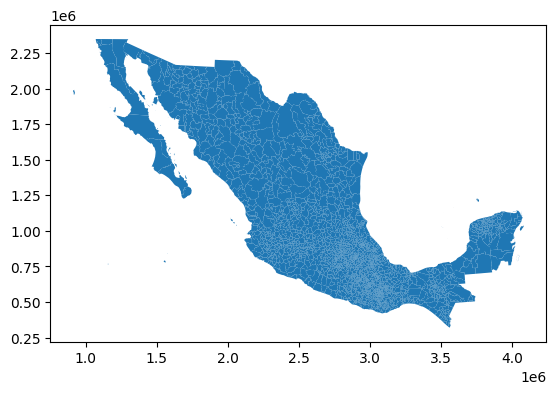

In [59]:
mun_df.plot()

When working with geospatial data, it is important to ensure that all datasets are properly aligned and in the same coordinate reference system (CRS). In this case, we have noticed that our polygon data is in a plain form, while our rasters are adapted to the globe form. Therefore, to correctly overlay our rasters onto the polygon data, we need to change the CRS of our polygon data to a globe-based projection. After conducting further research, we have determined that the "ESRI:54009" CRS is the best option for our data. This projection is a world-equivalent cylindrical projection, which means it accurately represents the size and shape of all land masses while minimizing distortion.

In [60]:
mun_df_esri = mun_df.to_crs("ESRI:54009")

<Axes: >

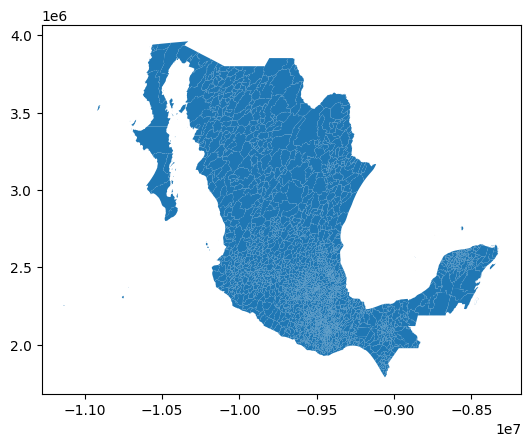

In [61]:
mun_df_esri.plot()

When we are not experts in the geodata or any topic, explore each step and bits is important to understand what we are doing, and what is happening.

In [62]:
# taking a chunk of our data
chunk = mun_df_esri[mun_df_esri['NOMGEO'].str.contains('Guadalajara')]
chunk

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
577,14039,14,039,Guadalajara,"POLYGON ((-9933770.500 2544176.533, -9933658.1..."


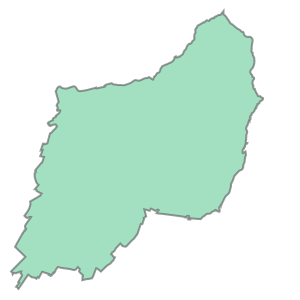

In [63]:
chunk_geometry = chunk.loc[577].geometry
chunk_geometry

In [64]:
# bounds of the geometry return the values, and the bound of the entire row 
# return the same data in a df with columns
chunk_geometry.bounds, chunk.bounds

((-9947500.356369967,
  2526420.108787522,
  -9931208.489283007,
  2544378.3654652946),
              minx         miny          maxx         maxy
 577 -9,947,500.36 2,526,420.11 -9,931,208.49 2,544,378.37)

### Integration with rasters
The idea is to take a polygon and make a clip in to the raster, once the first result work, we need to replicate into the next rasters. We are going to use GHS-BUILT-S rasters.

The GHS-BUILT-S - R2022A dataset is a spatial raster dataset that shows the distribution of built-up surfaces, expressed in square meters, with data from 1975 to 2030 in 5-year intervals. For the temporal anchor point of 2018, the data is published at 10m as observed from the S2 image data. Future predicted grids at the epochs 2025 and 2030 are provided accordingly to three scenarios extrapolating the past trends by a linear, a second-order polynomial, and a median solution. The dataset also reports on the total built-up surface and the built-up surface allocated to dominant non-residential (NRES) uses.

Checking relations...

In [65]:
target_states = mun_df_esri.query("NOMGEO == 'Mérida' or NOMGEO == 'Monterrey' or NOMGEO == 'Guadalajara' or NOMGEO == 'Mexicali'")
target_states

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
12,02002,02,002,Mexicali,"MULTIPOLYGON (((-10490680.193 3642450.367, -10..."
577,14039,14,039,Guadalajara,"POLYGON ((-9933770.500 2544176.533, -9933658.1..."
996,19039,19,039,Monterrey,"POLYGON ((-9427612.021 3147817.903, -9427607.4..."
2330,31050,31,050,Mérida,"POLYGON ((-8597541.258 2597093.431, -8597316.1..."


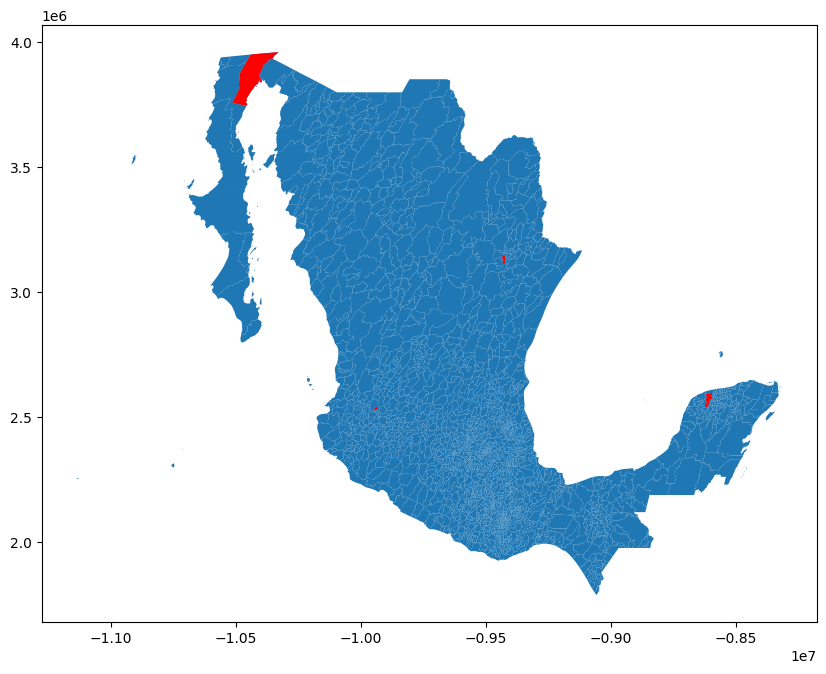

In [66]:

fig, ax = plt.subplots(figsize=(10, 10))
mun_df_esri.plot(ax=ax)
target_states.plot(ax=ax, color='red')
plt.show()


The raster has information of the entire world, we can't read the whole source, therefore we are going to use a window to capture the information within.

In [67]:
raster_url = 'http://tec-expansion-urbana-p.s3.amazonaws.com/GHSL/GHS_BUILT_S/GHS_BUILT_S_E2020_GLOBE_R2022A_54009_100_V1_0.tif'

In [68]:
# getting our delimitations
bounds = mun_df_esri.bounds
bbox = (bounds.minx.min(), bounds.miny.min(), bounds.maxx.max(), bounds.maxy.max())
bbox

(-11136792.015207246, 1789424.0876605099, -8319197.9989861, 3960386.322045107)

In [69]:
with rio.open(raster_url) as src:

    profile = src.profile.copy()
    transform = profile['transform']
    window = rio.windows.from_bounds(*bbox, transform).round_lengths().round_offsets()
    new_transform = src.window_transform(window)
    profile.update({
        'height': window.height,
        'width': window.width,
        'transform': new_transform})
    subset = src.read(window=window)

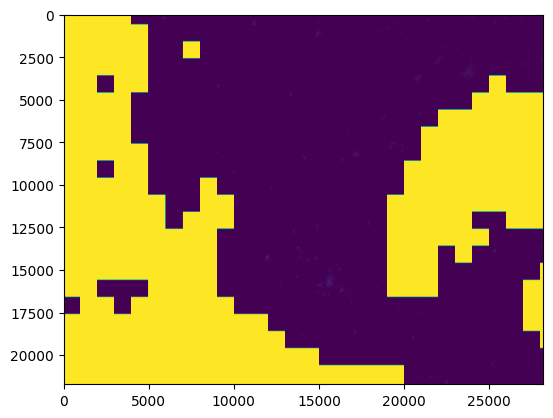

In [70]:
plt.imshow(subset[0])

It looks weird, let's ensure that this chunk contains all the information needed...

so I will clip a polygon on the current raster window

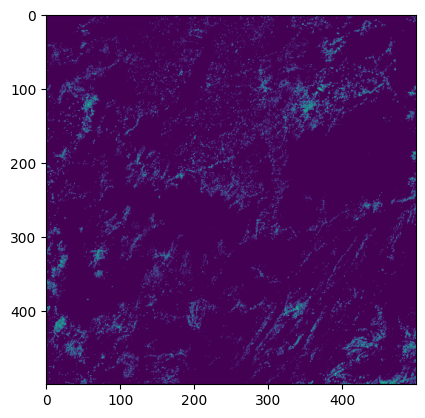

In [71]:
zoom_x1 = subset[0][15000:15500, 15000:15500]
zoom_x2 = zoom_x1[115:120, 55:60]

plt.imshow(zoom_x1)

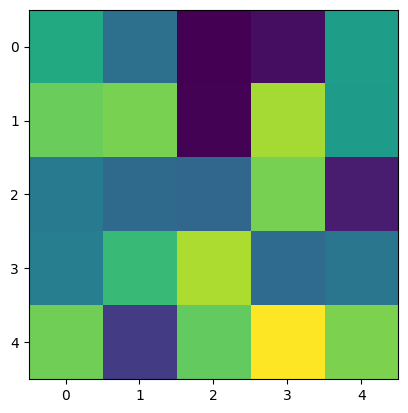

In [72]:
plt.imshow(zoom_x2)

Now with the window we can clip and get stats with zonal_stats function

In [73]:
results = zonal_stats(mun_df_esri['geometry'], subset[0], affine=src.transform, nodata=-999, stats='sum')
results[:5]

[{'sum': 7640922652.0},
 {'sum': 3559086476.0},
 {'sum': 6048536714.0},
 {'sum': 840013592.0},
 {'sum': 3274413769.0}]

let's merge this new data with the dataset

In [74]:
# don't modify the original df
mun_df_esri_stats = mun_df_esri.copy()

mun_df_esri_stats['mts_built'] = [val['sum'] for val in results]
mun_df_esri_stats


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,mts_built
0,01001,01,001,Aguascalientes,"POLYGON ((-9763561.303 2701712.806, -9763426.0...","7,640,922,652.00"
1,01002,01,002,Asientos,"POLYGON ((-9748415.565 2729458.549, -9748360.2...","3,559,086,476.00"
2,01003,01,003,Calvillo,"POLYGON ((-9817261.447 2706429.502, -9818061.1...","6,048,536,714.00"
3,01004,01,004,Cosío,"POLYGON ((-9765524.823 2744466.535, -9765510.6...","840,013,592.00"
4,01005,01,005,Jesús María,"POLYGON ((-9785899.303 2700549.051, -9785708.9...","3,274,413,769.00"
...,...,...,...,...,...,...
2464,32053,32,053,Villa González Ortega,"POLYGON ((-9723690.265 2772421.079, -9723689.5...","2,800,583,115.00"
2465,32054,32,054,Villa Hidalgo,"POLYGON ((-9704517.954 2756617.378, -9704503.0...","2,433,754,807.00"
2466,32055,32,055,Villanueva,"POLYGON ((-9801425.151 2775321.949, -9801404.7...","14,130,053,465.00"
2467,32056,32,056,Zacatecas,"POLYGON ((-9792480.422 2795430.577, -9792424.8...","2,863,119,468.00"


In [75]:
mun_df_esri.crs

<Derived Projected CRS: ESRI:54009>
Name: World_Mollweide
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Coordinate Operation:
- name: World_Mollweide
- method: Mollweide
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

It is moment to merge with the other rasters.

### ISSUE SOLVED
----
In the previus experimentation the final results per day were missing, the final fields give the same data per year, so I decide to use mask. The idea is to crop the polygon in the current window (country), and then sum all the values that are inside that window, we have to make sure nodata values...

In [76]:
def mts_built_per_year():
    results = []
    for year in range(1975, 2025, 5):#[1975]:#
        raster_url = f'http://tec-expansion-urbana-p.s3.amazonaws.com/GHSL/GHS_BUILT_S/GHS_BUILT_S_E{year}_GLOBE_R2022A_54009_100_V1_0.tif'
        with rio.open(raster_url) as src:

            #profile = src.profile.copy()
            #transform = profile['transform']
            #window = rio.windows.from_bounds(*bbox, transform).round_lengths().round_offsets()
            #new_transform = src.window_transform(window)
            #profile.update({
            #    'height': window.height,
            #    'width': window.width,
            #    'transform': new_transform})
            #subset = src.read(window=window)

            #zoom_x1 = subset[0][15000:15500, 15000:15500]
            #zoom_x2 = zoom_x1[115:120, 55:60]
            #print('nodata: ', src.nodata)
            #print(zoom_x2)
            #masked_data, masked_transform = mask.mask(src, mun_df_esri['geometry'][:3], crop=True)
            mun = []
            for polygon in mun_df_esri['geometry']:
                clip = mask.mask(src, [polygon], crop=True)[0][0]
                clip_ = np.where(clip == src.nodata, 0, clip)
                mts_built = clip_.sum()
                mun.append(mts_built)

            results.append(mun)
            #results.append(mask.mask(src, mun_df_esri['geometry'][:3], crop=True))
            #results.append(zonal_stats(mun_df_esri['geometry'][:3], subset[0], affine=src.transform, stats=['sum'], nodata=src.nodata))
            src.close()
    return results

In [77]:
mts_built_per_year_ = mts_built_per_year()

In [78]:
mun_df_esri_stats_per_year = mun_df_esri.copy()

for i, year in enumerate(range(1975, 2025, 5)):
    mun_df_esri_stats_per_year[f'mts_built_{year}'] = mts_built_per_year_[i]
mun_df_esri_stats_per_year

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,mts_built_1975,mts_built_1980,mts_built_1985,mts_built_1990,mts_built_1995,mts_built_2000,mts_built_2005,mts_built_2010,mts_built_2015,mts_built_2020
0,01001,01,001,Aguascalientes,"POLYGON ((-9763561.303 2701712.806, -9763426.0...",19348362,21316348,23989221,27370311,31041664,37130459,40273265,45662410,52498223,59732206
1,01002,01,002,Asientos,"POLYGON ((-9748415.565 2729458.549, -9748360.2...",1555118,1685580,1861718,2075620,2357002,2760549,3272708,4074526,5186686,7312624
2,01003,01,003,Calvillo,"POLYGON ((-9817261.447 2706429.502, -9818061.1...",2556024,2725559,2920497,3168827,3602370,4316303,4564605,4965170,5505950,6211424
3,01004,01,004,Cosío,"POLYGON ((-9765524.823 2744466.535, -9765510.6...",870778,883201,899977,919116,996194,1109241,1241375,1429175,1678140,1999969
4,01005,01,005,Jesús María,"POLYGON ((-9785899.303 2700549.051, -9785708.9...",2828033,3144196,3595968,4187099,4868249,5959336,6771137,8062056,9864663,12118141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464,32053,32,053,Villa González Ortega,"POLYGON ((-9723690.265 2772421.079, -9723689.5...",304490,328675,353906,382906,461549,583166,754666,995135,1341715,1961659
2465,32054,32,054,Villa Hidalgo,"POLYGON ((-9704517.954 2756617.378, -9704503.0...",310054,335196,365076,409903,467544,552599,717898,988475,1420374,2495988
2466,32055,32,055,Villanueva,"POLYGON ((-9801425.151 2775321.949, -9801404.7...",2801358,2883360,2978466,3086173,3387047,3811420,4150938,4660435,5362406,6604922
2467,32056,32,056,Zacatecas,"POLYGON ((-9792480.422 2795430.577, -9792424.8...",4647669,4936997,5262053,5639973,6207334,7050418,7595659,8359571,9358646,10947761


In [79]:
mun_df_esri_stats_per_year.query("NOMGEO == 'Monterrey' or NOMGEO == 'Guadalajara'")

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,mts_built_1975,mts_built_1980,mts_built_1985,mts_built_1990,mts_built_1995,mts_built_2000,mts_built_2005,mts_built_2010,mts_built_2015,mts_built_2020
577,14039,14,039,Guadalajara,"POLYGON ((-9933770.500 2544176.533, -9933658.1...",58872407,59142294,59431328,59764117,59953940,60177356,60326081,60494289,60690474,61022608
996,19039,19,039,Monterrey,"POLYGON ((-9427612.021 3147817.903, -9427607.4...",36442207,38742439,41681410,45350645,46452068,48326503,50205456,53387318,57366107,61040788


# Merging_

In this section, we will merge and integrate the different datasets to provide a comprehensive view of the urban landscape in Mexico.


In [147]:
list(sun.columns), list(mun_df_esri_stats_per_year.columns)

(['CVE_ENT',
  'NOM_ENT',
  'NOM_MUN',
  'CVE_LOC',
  'NOM_LOC',
  'CVE_SUN',
  'NOM_SUN',
  'POB_2018',
  'CVEGEO'],
 ['CVEGEO',
  'CVE_ENT',
  'CVE_MUN',
  'NOMGEO',
  'geometry',
  'mts_built_1975',
  'mts_built_1980',
  'mts_built_1985',
  'mts_built_1990',
  'mts_built_1995',
  'mts_built_2000',
  'mts_built_2005',
  'mts_built_2010',
  'mts_built_2015',
  'mts_built_2020'])

In [148]:
df_1990_simplied.shape, df_2000_simplied.shape, df_2010_simplied.shape, df_2020_simplied.shape, 

((2403, 2), (2427, 2), (2456, 2), (2469, 2))

In [149]:
# Merging all the censuses

# 1990, 2000
df_general = pd.merge(df_1990_simplied, df_2000_simplied, left_on="CVEGEO", right_on="CVEGEO")

# 1990, 2000, 2010
df_general = pd.merge(df_general, df_2010_simplied, left_on="CVEGEO", right_on="CVEGEO")

# 1990, 2000, 2010, 2020
df_general = pd.merge(df_general, df_2020_simplied, left_on="CVEGEO", right_on="CVEGEO")

In [150]:
df_general

,CVEGEO,P_TOTAL_1990,P_TOTAL_2000,P_TOTAL_2010,P_TOTAL_2020
0,01001,"506,274.00",643419,797010,948990
1,01002,"32,225.00",37763,45492,51536
2,01003,"48,440.00",51291,54136,58250
3,01004,"10,247.00",12619,15042,17000
4,01005,"41,092.00",64097,99590,129929
...,...,...,...,...,...
2382,32052,"12,675.00",14443,18269,19525
2383,32053,"12,226.00",11870,12893,13208
2384,32054,"14,076.00",15746,18490,19446
2385,32055,"35,373.00",32140,29395,31558


In [151]:
df_general.query("CVEGEO == '12001'")

,CVEGEO,P_TOTAL_1990,P_TOTAL_2000,P_TOTAL_2010,P_TOTAL_2020
337,12001,"593,212.00",722499,789971,779566


In [152]:
# Merging censuses and mts_built
df_general = pd.merge(df_general, mun_df_esri_stats_per_year, left_on='CVEGEO', right_on='CVEGEO')
df_general

,CVEGEO,P_TOTAL_1990,P_TOTAL_2000,P_TOTAL_2010,P_TOTAL_2020,CVE_ENT,CVE_MUN,NOMGEO,geometry,mts_built_1975,mts_built_1980,mts_built_1985,mts_built_1990,mts_built_1995,mts_built_2000,mts_built_2005,mts_built_2010,mts_built_2015,mts_built_2020
0,01001,"506,274.00",643419,797010,948990,01,001,Aguascalientes,"POLYGON ((-9763561.303 2701712.806, -9763426.0...",19348362,21316348,23989221,27370311,31041664,37130459,40273265,45662410,52498223,59732206
1,01002,"32,225.00",37763,45492,51536,01,002,Asientos,"POLYGON ((-9748415.565 2729458.549, -9748360.2...",1555118,1685580,1861718,2075620,2357002,2760549,3272708,4074526,5186686,7312624
2,01003,"48,440.00",51291,54136,58250,01,003,Calvillo,"POLYGON ((-9817261.447 2706429.502, -9818061.1...",2556024,2725559,2920497,3168827,3602370,4316303,4564605,4965170,5505950,6211424
3,01004,"10,247.00",12619,15042,17000,01,004,Cosío,"POLYGON ((-9765524.823 2744466.535, -9765510.6...",870778,883201,899977,919116,996194,1109241,1241375,1429175,1678140,1999969
4,01005,"41,092.00",64097,99590,129929,01,005,Jesús María,"POLYGON ((-9785899.303 2700549.051, -9785708.9...",2828033,3144196,3595968,4187099,4868249,5959336,6771137,8062056,9864663,12118141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,32052,"12,675.00",14443,18269,19525,32,052,Villa García,"POLYGON ((-9742828.125 2721977.373, -9740810.1...",542994,587823,639566,693726,748496,819100,912299,1048466,1329183,2297463
2383,32053,"12,226.00",11870,12893,13208,32,053,Villa González Ortega,"POLYGON ((-9723690.265 2772421.079, -9723689.5...",304490,328675,353906,382906,461549,583166,754666,995135,1341715,1961659
2384,32054,"14,076.00",15746,18490,19446,32,054,Villa Hidalgo,"POLYGON ((-9704517.954 2756617.378, -9704503.0...",310054,335196,365076,409903,467544,552599,717898,988475,1420374,2495988
2385,32055,"35,373.00",32140,29395,31558,32,055,Villanueva,"POLYGON ((-9801425.151 2775321.949, -9801404.7...",2801358,2883360,2978466,3086173,3387047,3811420,4150938,4660435,5362406,6604922


In [153]:
# Merging SUN and df_general
sun_without_loc['CVEGEO'] = sun_without_loc['CVEGEO'].astype('int64')
df_general['CVEGEO'] = df_general['CVEGEO'].astype('int64')
df_general = pd.merge(sun_without_loc, df_general, left_on="CVEGEO", right_on="CVEGEO")

In [154]:
df_general.columns

Index(['CVE_ENT_x', 'NOM_ENT', 'NOM_MUN', 'CVE_LOC', 'NOM_LOC', 'CVE_SUN',
       'NOM_SUN', 'POB_2018', 'CVEGEO', 'P_TOTAL_1990', 'P_TOTAL_2000',
       'P_TOTAL_2010', 'P_TOTAL_2020', 'CVE_ENT_y', 'CVE_MUN', 'NOMGEO',
       'geometry', 'mts_built_1975', 'mts_built_1980', 'mts_built_1985',
       'mts_built_1990', 'mts_built_1995', 'mts_built_2000', 'mts_built_2005',
       'mts_built_2010', 'mts_built_2015', 'mts_built_2020'],
      dtype='object')

In [155]:
df_general.shape

(724, 27)

In [156]:
df_general

,CVE_ENT_x,NOM_ENT,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,NOM_SUN,POB_2018,CVEGEO,P_TOTAL_1990,...,mts_built_1975,mts_built_1980,mts_built_1985,mts_built_1990,mts_built_1995,mts_built_2000,mts_built_2005,mts_built_2010,mts_built_2015,mts_built_2020
0,1,Aguascalientes,Jesús María,NaN,NaN,M01.01,Aguascalientes,116700,1005,"41,092.00",...,2828033,3144196,3595968,4187099,4868249,5959336,6771137,8062056,9864663,12118141
1,1,Aguascalientes,Aguascalientes,NaN,NaN,M01.01,Aguascalientes,897331,1001,"506,274.00",...,19348362,21316348,23989221,27370311,31041664,37130459,40273265,45662410,52498223,59732206
2,2,Baja California,Tecate,NaN,NaN,M02.03,Tijuana,115570,2003,"51,557.00",...,609596,654287,726432,814495,1300189,2182619,2928839,4197121,6174322,10243644
3,2,Baja California,Tijuana,NaN,NaN,M02.03,Tijuana,1798741,2004,"747,381.00",...,40701530,42072181,44061348,46626455,52403702,60884930,63841590,68390529,73924882,78633335
4,2,Baja California,Mexicali,NaN,NaN,M02.02,Mexicali,1065882,2002,"601,938.00",...,35712103,37601694,40050187,42982069,45075065,48065755,51672518,56841666,62919081,68319741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,32,Zacatecas,Nochistlán de Mejía,"320,340,001.00",Nochistlán de Mejía,P32.06,Nochistlán de Mejía,17807,32034,"32,327.00",...,1382775,1446651,1531091,1630912,1823756,2136407,2432808,2924322,3699320,5086667
720,32,Zacatecas,Ojocaliente,"320,360,001.00",Ojocaliente,P32.07,Ojocaliente,22867,32036,"33,341.00",...,1831915,1857468,1889216,1931859,2112503,2365095,2776772,3348905,4162244,5735192
721,32,Zacatecas,Río Grande,"320,390,001.00",Río Grande,C32.02,Río Grande,40077,32039,"57,834.00",...,5896787,5976094,6063733,6161512,6486111,6933132,7344736,7862298,8480927,9287207
722,32,Zacatecas,Sombrerete,"320,420,001.00",Sombrerete,P32.08,Sombrerete,25232,32042,"63,546.00",...,6405849,6481417,6571021,6662832,6867830,7160905,7915127,8915327,10362314,13293831


In [157]:
df_general_proccessed = df_general[['CVE_ENT_x', 'NOM_ENT', 'CVE_MUN', 'NOM_MUN', 'CVE_LOC', 'NOM_LOC',
       'CVE_SUN', 'POB_2018', 'P_TOTAL_1990',
       'P_TOTAL_2000', 'P_TOTAL_2010', 'P_TOTAL_2020', 'CVEGEO', 'NOMGEO', 'mts_built_1975', 'mts_built_1980',
       'mts_built_1985', 'mts_built_1990', 'mts_built_1995', 'mts_built_2000',
       'mts_built_2005', 'mts_built_2010', 'mts_built_2015', 'mts_built_2020']]
df_general_proccessed.columns = ['CVE_ENT', 'NOM_ENT', 'CVE_MUN', 'NOM_MUN', 'CVE_LOC', 'NOM_LOC',
       'CVE_SUN', 'POB_2018', 'P_TOTAL_1990',
       'P_TOTAL_2000', 'P_TOTAL_2010', 'P_TOTAL_2020', 'CVEGEO', 'NOMGEO', 'mts_built_1975', 'mts_built_1980',
       'mts_built_1985', 'mts_built_1990', 'mts_built_1995', 'mts_built_2000',
       'mts_built_2005', 'mts_built_2010', 'mts_built_2015', 'mts_built_2020']
df_general_proccessed

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,POB_2018,P_TOTAL_1990,P_TOTAL_2000,...,mts_built_1975,mts_built_1980,mts_built_1985,mts_built_1990,mts_built_1995,mts_built_2000,mts_built_2005,mts_built_2010,mts_built_2015,mts_built_2020
0,1,Aguascalientes,005,Jesús María,NaN,NaN,M01.01,116700,"41,092.00",64097,...,2828033,3144196,3595968,4187099,4868249,5959336,6771137,8062056,9864663,12118141
1,1,Aguascalientes,001,Aguascalientes,NaN,NaN,M01.01,897331,"506,274.00",643419,...,19348362,21316348,23989221,27370311,31041664,37130459,40273265,45662410,52498223,59732206
2,2,Baja California,003,Tecate,NaN,NaN,M02.03,115570,"51,557.00",77795,...,609596,654287,726432,814495,1300189,2182619,2928839,4197121,6174322,10243644
3,2,Baja California,004,Tijuana,NaN,NaN,M02.03,1798741,"747,381.00",1210820,...,40701530,42072181,44061348,46626455,52403702,60884930,63841590,68390529,73924882,78633335
4,2,Baja California,002,Mexicali,NaN,NaN,M02.02,1065882,"601,938.00",764602,...,35712103,37601694,40050187,42982069,45075065,48065755,51672518,56841666,62919081,68319741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,32,Zacatecas,034,Nochistlán de Mejía,"320,340,001.00",Nochistlán de Mejía,P32.06,17807,"32,327.00",29282,...,1382775,1446651,1531091,1630912,1823756,2136407,2432808,2924322,3699320,5086667
720,32,Zacatecas,036,Ojocaliente,"320,360,001.00",Ojocaliente,P32.07,22867,"33,341.00",38219,...,1831915,1857468,1889216,1931859,2112503,2365095,2776772,3348905,4162244,5735192
721,32,Zacatecas,039,Río Grande,"320,390,001.00",Río Grande,C32.02,40077,"57,834.00",59330,...,5896787,5976094,6063733,6161512,6486111,6933132,7344736,7862298,8480927,9287207
722,32,Zacatecas,042,Sombrerete,"320,420,001.00",Sombrerete,P32.08,25232,"63,546.00",61652,...,6405849,6481417,6571021,6662832,6867830,7160905,7915127,8915327,10362314,13293831


In [158]:
df_general_proccessed.query('NOM_MUN == "Rincón de Romos"')

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,POB_2018,P_TOTAL_1990,P_TOTAL_2000,...,mts_built_1975,mts_built_1980,mts_built_1985,mts_built_1990,mts_built_1995,mts_built_2000,mts_built_2005,mts_built_2010,mts_built_2015,mts_built_2020
387,1,Aguascalientes,007,Rincón de Romos,"10,070,001.00",Rincón de Romos,C01.01,30969,"33,781.00",41655,...,1718382,1851528,2043021,2266205,2481081,2787166,3158625,3789614,4706849,5740052


In [169]:
with open('municipios.geojson' , 'w') as file:
    file.write(df_general_proccessed.to_json())

with open('municipios.csv' , 'w') as file:
    file.write(df_general_proccessed.to_csv())

In [168]:
df_general_proccessed.query('CVEGEO == 3008')

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,CVE_SUN,POB_2018,P_TOTAL_1990,P_TOTAL_2000,...,mts_built_1975,mts_built_1980,mts_built_1985,mts_built_1990,mts_built_1995,mts_built_2000,mts_built_2005,mts_built_2010,mts_built_2015,mts_built_2020
390,3,Baja California Sur,008,Los Cabos,"30,080,001.00",San José del Cabo,P03.04,307605,"43,920.00",105469,...,19042365,19124390,19219191,19335777,19862926,20554217,21197791,22018665,22926837,23630540


# Optimized Pipeline System_

In this section, we will implement all of the analyses as an optimized pipeline system. Each analysis will be configured as an independent analysis, and the results will be merged at the end to produce the final exploratory geojson.
